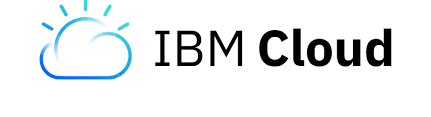
# CASE STUDY - convolutional neural networks

In [2]:
pip install seaborn


In [2]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import csv
import joblib
import time
from collections import Counter
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Use a valid Matplotlib style
plt.style.use('seaborn-v0_8-muted')
%matplotlib inline


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

Synopsis
----------

You were hired at AAVAIL to be a member of a data science team that works closely together.  Some of your first projects
are meant to help marketing with customer retention and to investigate market specific trends. There are also some
projects relating to user comments that are getting off the ground.  However, you will also be working alongside
the deep-learning specialists that maintain the core product at AAVAIL---its audio and visual manipulation models.

Because the team meets regularly all new data science hires are expected to go through a series deep-learning tutorials
to ensure that they can contribute to conversations about the core product.   The first in this series is the following
tutorial on CNNs.  You will be guided through the following parts.

  1. Environment setup
  2. Model scaffolding using Keras
  3. Logging and Model serialization
  4. Model iteration

## Fashion MNIST

>One project that the data science team at AAVAIL has been tasked with is ensuring that the video feeds are in fact news video feeds.  There are people that are performing quality assurance on these feeds, but eventually the data science team will need to build a service that samples a number of frames from a video, then identifies objects in the images, flagging for review any feeds that may be different.

A solid benchmark dataset for this task is the Fashion MNIST dataset.  

* training set - 60,000 images
* test set - 10,000 images
* images are 28 pixels x 28 pixels
* classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

## PART 1 - environment setup

In [5]:
## if you wish to work with tensorflow v1 then ask it to emulate version 2 behavior
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
print(tf.__version__)

## check hardware availability
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.16.2
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7578886854084991093
xla_global_id: -1
]


In [6]:
### load the data  
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 
               'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(class_names)

## Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

X_train = train_images
X_test = test_images
y_train = train_labels
y_test = test_labels

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### QUESTION 1

Visualize a sample of the images to QA the data set (for instance plot one image of each class). Then, print a summary of the data (for instance, the shape of training set, the shape of the test set, the number of sample per class...).

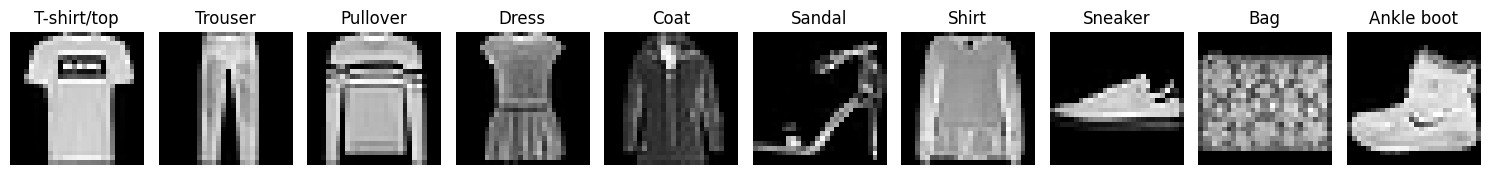

In [10]:
## YOUR CODE HERE (visualization code)


# Set up a plot to visualize one image of each class
fig, axes = plt.subplots(1, 10, figsize=(15, 15))

# Loop over each class and plot an example image
for i in range(10):
    axes[i].imshow(train_images[train_labels == i][0], cmap='gray')
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()


In [11]:
## YOUR CODE HERE (Summarize the data)

# Print the shape of the training and test datasets
print(f"Shape of training images: {train_images.shape}")
print(f"Shape of test images: {test_images.shape}")
print(f"Number of classes: {num_classes}")

# Display basic statistics about the pixel values
print("\nTraining data statistics:")
print(f"Min pixel value in training images: {train_images.min()}")
print(f"Max pixel value in training images: {train_images.max()}")
print(f"Mean pixel value in training images: {train_images.mean()}")
print(f"Standard deviation of pixel values in training images: {train_images.std()}")

# Count the number of samples per class
from collections import Counter
class_counts = Counter(train_labels)
for i in range(num_classes):
    print(f"Class {class_names[i]}: {class_counts[i]} samples")


Shape of training images: (60000, 28, 28)
Shape of test images: (10000, 28, 28)
Number of classes: 10

Training data statistics:
Min pixel value in training images: 0.0
Max pixel value in training images: 1.0
Mean pixel value in training images: 0.2860405969887955
Standard deviation of pixel values in training images: 0.35302424451492237
Class T-shirt/top: 6000 samples
Class Trouser: 6000 samples
Class Pullover: 6000 samples
Class Dress: 6000 samples
Class Coat: 6000 samples
Class Sandal: 6000 samples
Class Shirt: 6000 samples
Class Sneaker: 6000 samples
Class Bag: 6000 samples
Class Ankle boot: 6000 samples


Take a moment to understand how the data set is built, especially what are the 3 dimensions of X_train and X_test.

### QUESTION 2

In this question you are asked to build a base model. The base model that we want to build is composed of a PCA model followed by a classic machine learning classifier. The PCA takes as input the images that have been flattened and creates a representation of the images with few features (the first n principal components). Then, the classifier will classify the images based on this reduced representation. Following the best practices we will create a sklearn Pipeline and pass this pipeline in a grid search to optimize the hyper parameters. You are free to use the classifier that you think will perform best in this pipeline.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import joblib
import time
import os
import numpy as np

# Flatten the images
X_train_flat = np.array([i.flatten() for i in train_images])
X_test_flat = np.array([i.flatten() for i in test_images])

# Initialize PCA with a variable number of components
pca = PCA()

# Initialize the classifier with the saga solver
estimator = LogisticRegression(solver='saga', max_iter=500)

# Create the pipeline with scaling, PCA, and classifier
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', pca),
                 ('clf', estimator)])

# Define hyperparameters for GridSearchCV
param_grid = {
    'pca__n_components': [50, 100, 150],  # Number of PCA components
    'clf__C': [0.1, 1, 10]  # Regularization parameter for Logistic Regression
}

# Create a "saved" folder to save the trained model
if not os.path.isdir("saved"):
    os.mkdir("saved")

saved_model_filename = os.path.join("saved", 'ml-model.joblib')

# Check if the model already exists
if not os.path.exists(saved_model_filename):
    time_start = time.time()

    # Perform grid search with cross-validation
    grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1)
    
    # Fit the model with training data
    grid.fit(X_train_flat, train_labels)

    print("Saving the pipeline")
    joblib.dump(grid, saved_model_filename)
    print("Training time:", time.strftime('%H:%M:%S', time.gmtime(time.time() - time_start)))
else:
    print(f"Loading {saved_model_filename} from file")
    grid = joblib.load(saved_model_filename)


Loading saved\ml-model.joblib from file


In [16]:
# Evaluate your model using the classification_report() function
y_pred = grid.predict(X_test_flat)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

 T-shirt/top       0.80      0.82      0.81      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.73      0.73      0.73      1000
       Dress       0.83      0.86      0.85      1000
        Coat       0.73      0.75      0.74      1000
      Sandal       0.94      0.93      0.93      1000
       Shirt       0.62      0.56      0.59      1000
     Sneaker       0.90      0.93      0.92      1000
         Bag       0.93      0.94      0.94      1000
  Ankle boot       0.95      0.94      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## PART 2 -  model scaffolding using Keras

Create a function that returns a model using ``keras.models.Sequential()`` and ensure that you pass ``activation_function`` as an argument.  Instaintiate a version of the model and print the summary.  This function is just meant to return a simple multilayer perceptron network.


### QUESTION 3

In this question you are asked to build a function that created a simple multilayer perceptron network. To build a sequential model we first need to initialize the Sequential object, then we sequentially add the layers of the model to that object using the add() method.

If your are not familiar with the Sequential class of Keras take a quick look at this documentation : https://keras.io/api/models/sequential/

The following link list all the layers that you can add to a Keras sequential object : https://keras.io/api/layers/


In [19]:
def build_mlp(activation_fn):
    """
    This Function creates a simple Dense (or multilayer perceptron) network.
    """
    
    # Initialize the Sequential object
    model = keras.Sequential()
    
    # Add an Input layer and flatten the input (flatten the 28x28 images)
    model.add(layers.Input(shape=(28, 28)))  # Instead of passing input_shape to Flatten
    
    # Add a Dense layer to the sequence (hidden layer with 128 neurons)
    model.add(layers.Dense(128, activation=activation_fn))  # Apply the given activation function
    
    # Add the last dense layer to the sequence (output layer)
    model.add(layers.Dense(10, activation='softmax'))  # Output layer for 10 classes, softmax activation for classification
    
    return model

# Instantiate the model with ReLU activation for the hidden layer
model_simple = build_mlp(activation_fn='relu')

# Print the model summary
model_simple.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 28, 128)        │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 28, 10)         │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,002 (19.54 KB)

 Trainable params: 5,002 (19.54 KB)

 Non-trainable params: 0 (0.00 B)

We encourage you to modify the structure of the network. You can add new layers, change the number of neurons per layer or add dropout layers.

### QUESTION 4

Create another version of your neural network.  This time you should build a proper CNN.  Remember that one pattern to consider starting from is alternating ``Con2D`` and ``MaxPooling2D`` layers.  This is often followed by a couple of ``Dense`` layers.  Recall that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The output of the last ``Dense`` layer should correspond to the number of classes and generally uses a 'softmax' activation.  Use `model.summary()` to ensure a cohesive architecture.

In [21]:
import keras
from tensorflow.keras import layers

def build_cnn(activation_fn='relu'):
    """
    This function creates a convolutional neural network (CNN)
    """
    
    # Initialize the Sequential model
    model = keras.Sequential()
    
    # Add a Conv2D layer
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation=activation_fn, input_shape=(28, 28, 1)))
    
    # Add a MaxPooling2D layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add another Conv2D layer
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation=activation_fn))
    
    # Add another MaxPooling2D layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten the 3D tensor to 1D for the Dense layer
    model.add(layers.Flatten())
    
    # Add a Dense layer
    model.add(layers.Dense(64, activation=activation_fn))
    
    # Add the output Dense layer with softmax activation for classification
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

# Instantiate the model and print the summary
model = build_cnn(activation_fn='relu')
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

## PART 3 - logging and Model serialization

You can use a trained model without having to retrain it.  Your can also continue training a model to pick-up training where you left off.  The `tf.keras.callbacks.ModelCheckpoint` callback allows to continually save the model both during and at the end of training.  For long running models this is ideal in case the training is interrupted.  Otherwise you can 
used `model.save()` and `model.load()`.  In this part you will create a function that accomplished a few things at once. 

### QUESTION 5

In this question you will create a function that intend to :

1. save your models so that each iteration only needs to be run once
2. save the specifics of your model in a log file 

  * optimizer 
  * loss_fn 
  * test_loss
  * test_accuracy
  * any notes

In [24]:
import os
import csv
import keras
from tensorflow.keras.models import Sequential

def train_network(model_name, model, loss_fn, X_train, y_train, X_test, y_test, optimizer='adam'):
    """
    This function compiles, trains, saves the keras model, and logs the details.
    Input : 
        - model_name : the name of the model (used to save the model file)
        - model : The keras Sequential model
        - loss_fn : the name of the loss function used to train the model
        - optimizer : the name of the optimizer used to train the model
        - X_train : the training data
        - y_train : the training labels
        - X_test : the test data
        - y_test : the test labels
    """
    # Create a directory for saving the model if it doesn't exist
    save_dir = 'saved'
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    saved_model = os.path.join(save_dir, f"{model_name}.h5")
    
    # If the model has not been trained, compile it, train it, and save it
    if not os.path.exists(saved_model):
        # Compile the model using the specified loss function and optimizer
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
        
        # Train the model using the fit method
        model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
        
        # Save the model
        model.save(saved_model)

        # Evaluate the model on the test set
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
        
        # Save a log file with the model details
        log_file = os.path.join(save_dir, f"{model_name}.log")
        with open(log_file, 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["loss_function", loss_fn])
            writer.writerow(["optimizer", optimizer])
            writer.writerow(["test_loss", test_loss])
            writer.writerow(["test_acc", test_acc])
        
    else:
        # If the model has already been trained, load it
        print("... loading saved model")
        model = keras.models.load_model(saved_model)
                    
    return model


## PART 4 - model iteration

### Question 6

Using the functions that you created in the previous questions build the model and train it on the MNIST dataset.

In [27]:
import keras
from tensorflow.keras.datasets import mnist
import numpy as np

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess the data: Flatten the images and normalize the pixel values
# Reshape the input data to (batch_size, height, width, channels)
X_train_flat = X_train.reshape(-1, 28, 28, 1) / 255.0  # Flatten and normalize the images
X_test_flat = X_test.reshape(-1, 28, 28, 1) / 255.0  # Flatten and normalize the images

# Define the loss function and optimizer
loss_fn = 'sparse_categorical_crossentropy'  # Using sparse categorical cross-entropy for multi-class classification
optimizer = 'adam'  # Using Adam optimizer

# Build the MLP model using the previously created function
model_name = "mlp_mnist"
model = build_cnn(activation_fn='relu')  # Assuming you are using CNN for this task

# Train and save/load the model using the previously created function
trained_model = train_network(model_name, model, loss_fn, X_train_flat, y_train, X_test_flat, y_test, optimizer)

# Evaluate the model after training
test_loss, test_acc = trained_model.evaluate(X_test_flat, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.8786 - loss: 0.4057 - val_accuracy: 0.9827 - val_loss: 0.0585
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.9840 - loss: 0.0566 - val_accuracy: 0.9866 - val_loss: 0.0401
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.9890 - loss: 0.0369 - val_accuracy: 0.9878 - val_loss: 0.0366
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.9920 - loss: 0.0282 - val_accuracy: 0.9895 - val_loss: 0.0325
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.9935 - loss: 0.0207 - val_accuracy: 0.9903 - val_loss: 0.0305
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.9946 - loss: 0.0184 - val_accuracy: 0.9888 - val_loss: 0.0335
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.9963 - loss: 0.0115 - val_accuracy: 0.9906 - val_loss: 0.0296
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.9968 - loss: 0.0095 - 

313/313 - 3s - 9ms/step - accuracy: 0.9891 - loss: 0.0383
313/313 - 3s - 9ms/step - accuracy: 0.9891 - loss: 0.0383
Test accuracy: 0.9890999794006348


In [29]:
## YOUR CODE HERE (build and train a CNN)


## For the CNN we have to add a third dimension to each sample image. 
## This dimension is called channel and is expected by the CNN2D layer. 
## Here the channel value is 1 because we have black and white images. 
## We would have to set this value to 3 for colored images.
import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
import numpy as np

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess the data: Add a channel dimension and normalize the pixel values
X_train_1 = np.expand_dims(X_train, -1) / 255.0  # Add channel dimension and normalize
X_test_1 = np.expand_dims(X_test, -1) / 255.0  # Add channel dimension and normalize

# Define the CNN model
def build_cnn():
    model = models.Sequential()
    
    # Add a Conv2D layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    
    # Add a MaxPooling2D layer
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Add another Conv2D layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Add another MaxPooling2D layer
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten the output from the Conv2D layers
    model.add(layers.Flatten())
    
    # Add a Dense layer for classification
    model.add(layers.Dense(64, activation='relu'))
    
    # Add the output layer with softmax activation for multi-class classification
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

# Build the model
model = build_cnn()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_1, y_train, epochs=10, batch_size=64, validation_data=(X_test_1, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_1, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.8843 - loss: 0.3907 - val_accuracy: 0.9821 - val_loss: 0.0533
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.9834 - loss: 0.0535 - val_accuracy: 0.9828 - val_loss: 0.0535
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.9890 - loss: 0.0361 - val_accuracy: 0.9862 - val_loss: 0.0397
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.9927 - loss: 0.0252 - val_accuracy: 0.9892 - val_loss: 0.0310
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.9934 - loss: 0.0206 - val_accuracy: 0.9904 - val_loss: 0.0301
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.9957 - loss: 0.0133 - val_accuracy: 0.9914 - val_loss: 0.0311
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.9960 - loss: 0.0119 - val_accuracy: 0.9910 - val_loss: 0.0307
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.9968 - loss: 0.0105 - 